## 사용자 기반 협업 필터링 추천시스템

In [4]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
user='root'
pwd='1234'
server = 'localhost'
db_name = 'movie_review'
engine = create_engine(f'mysql+pymysql://{user}:{pwd}@{server}/{db_name}?charset=utf8', convert_unicode=True)

connect = engine.connect()

raw_data = pd.read_sql_table('raw_file', connect)
raw_data

,id,user,title,genre,score
0,125,tnen,기방도령,코미디,4
1,126,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,127,tnen,사바하,미스터리,10
3,128,tnen,글래스,드라마,10
4,129,tnen,모털 엔진,액션,10
...,...,...,...,...,...
7004,7129,phs3,쓰리 빌보드,드라마,7
7005,7130,phs3,토르: 천둥의 신,판타지,3
7006,7131,1432,어벤져스: 인피니티 워,액션,10
7007,7132,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10


In [6]:
# 10개 평가 이하 영화 제거
def refinding_df(raw_data):
    title_number_df = raw_data.groupby('title').count().sort_values('user')
#     print(title_number_df)
    title_under_10 = title_number_df[title_number_df.user <= 10]
#     print(title_under_10)
    title_under_10_list = list(title_under_10.index)
    
    for title in title_under_10_list:
        raw_data = raw_data[raw_data['title'] != title]
    return raw_data
    
raw_df = refinding_df(raw_data)
raw_df

,id,user,title,genre,score
2,127,tnen,사바하,미스터리,10
11,136,tnen,서치,드라마,10
15,140,tnen,인랑,SF,1
18,143,tnen,앤트맨과 와스프,액션,10
19,144,tnen,마녀,미스터리,6
...,...,...,...,...,...
7001,7126,phs3,어벤져스: 인피니티 워,액션,10
7003,7128,phs3,곤지암,공포,8
7006,7131,1432,어벤져스: 인피니티 워,액션,10
7007,7132,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10


In [7]:
df = raw_df.copy()
df.tail(2)

,id,user,title,genre,score
7007,7132,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10
7008,7133,1432,위대한 쇼맨,드라마,1


In [8]:
df = df.drop(['id'], axis=1)
df.tail(2)

,user,title,genre,score
7007,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10
7008,1432,위대한 쇼맨,드라마,1


### DATA 탐색

In [9]:
user_num = df['user'].unique().shape[0]
movie_num = df.title.unique().shape[0]
print(f'유저의 수는 {user_num}명이고, \n 영화의 수는 {movie_num}이다.')

유저의 수는 159명이고, 
 영화의 수는 98이다.


## 평점을 많이 남긴 유저 탑 10

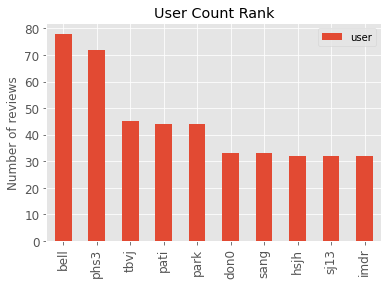

In [10]:
user_top_10 = df.user.value_counts()[:10]
plt.style.use('ggplot')
user_top_10.plot(kind='bar', title="User Count Rank", legend=True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

## 유저들로 부터 평점을 많이 받은 영화 탑10

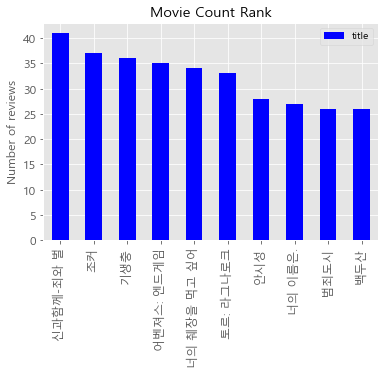

In [11]:
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
# font_name
rc('font', family=font_name)
movie_top_10 = df.title.value_counts()[:10]
movie_top_10.plot(kind='bar', title="Movie Count Rank", legend=True, fontsize = 12, color = 'b')
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

## 평점 랭킹

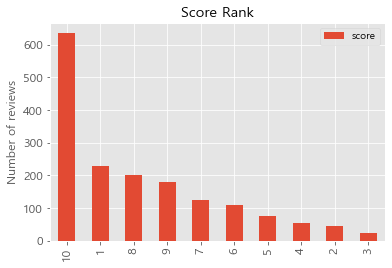

In [12]:
score_ranking = df.score.value_counts()
plt.style.use('ggplot')
score_ranking.plot(kind='bar', title='Score Rank', legend=True, fontsize=12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

## Colaborative Filtering
#### 1. 행렬로 만든다
#### 2. 추천하고자 하는 유저가 입력되면 코사인 유사도를 이용하여 각 유사도를 구한다
#### 3. 추천하고자 하는 유저(t)와 K명의 비슷한 유저들의 아이템에 대한 평점을 이용하여 t가 아직 평가하지 않은 영화의 평점을 예측해서 유저에게 추천한다
#### 4. Validation 한다

In [13]:
# LavelEncoder를 이용하여 수치화
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    labeling_data = Lec.fit_transform(df_copy[column_name].values)
    df_label = pd.DataFrame(labeling_data, columns=[column_name+'_label'],index=df_copy.index)
    return df_label
#     print(labeling_data)
df_user = execute_labeling('user')
df_title = execute_labeling('title')

df_copy = df.copy()
df_copy = df_copy.drop(df_copy.columns[[0,1]], axis = 1)
df_label = pd.concat([df_user, df_title,df_copy], axis = 1)
df_label.tail(5)

,user_label,title_label,genre,score
7001,104,66,액션,10
7003,104,8,공포,8
7006,1,66,액션,10
7007,1,54,드라마,10
7008,1,70,드라마,1


In [14]:
movie_list = list(df['title'].unique())

movie_list = sorted(movie_list, key=str)
movie_list
df_matrix = pd.DataFrame(columns = ['user'] + movie_list)
df_matrix

,user,1987,82년생 김지영,걸캅스,검객,겨울왕국 2,고질라 VS. 콩,고질라: 킹 오브 몬스터,곡성(哭聲),곤지암,...,콜,킹스맨: 골든 서클,탐정: 리턴즈,택시운전사,터미네이터: 다크 페이트,테넷,토르: 라그나로크,포드 V 페라리,혹성탈출: 종의 전쟁,히트맨


In [15]:
user_num = len(df_label['user_label'].unique())
movie_num = len(df_label['title_label'].unique())

user_score_list = []
for num in range(0, user_num):
    user_score_list = [0 for i in range(movie_num)]
    df_tmp = df_label[df_label['user_label'] == num]
    for j in df_tmp.index:
        user_score_list[df_tmp.loc[j]['title_label']-1] = df_tmp.loc[j]['score']
        df_matrix.loc[num] = [num] + user_score_list
type(df_matrix)

pandas.core.frame.DataFrame

In [16]:
df_matrix

,user,1987,82년생 김지영,걸캅스,검객,겨울왕국 2,고질라 VS. 콩,고질라: 킹 오브 몬스터,곡성(哭聲),곤지암,...,콜,킹스맨: 골든 서클,탐정: 리턴즈,택시운전사,터미네이터: 다크 페이트,테넷,토르: 라그나로크,포드 V 페라리,혹성탈출: 종의 전쟁,히트맨
0,0,10,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,154,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,155,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,10,0,0
156,156,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,157,0,0,0,1,0,5,0,0,0,...,0,0,0,8,1,0,0,0,0,0


#### 5. pickle 를 사용해서 데이터프레임을 바이너리로 바꾼다(유티릴티 행렬)

In [17]:
import pickle
file = df_matrix
directory = open('uilitymatrix','wb')
pickle.dump(file, directory)
directory.close()

In [18]:
user_name = df['user'].unique()
user_name = sorted(user_name, key=str)
user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']
file_user = user_name

directory_user = open('user_name', 'wb')
pickle.dump(file_user,directory_user)
directory_user.close()

In [21]:
f = open('uilitymatrix','rb')
uilitymatrix = pickle.load(f)
df = uilitymatrix
df.tail

<bound method NDFrame.tail of     user 1987 82년생 김지영 걸캅스  검객 겨울왕국 2 고질라 VS. 콩 고질라: 킹 오브 몬스터 곡성(哭聲) 곤지암  ...  \
0      0   10        0   0   0      0         0             0      5   0  ...   
1      1    0        0   0   0      0         0             0      0   0  ...   
2      2    0        0   0   0      0         0             0      0   0  ...   
3      3    0        0   0   0      0         0             0      0   0  ...   
4      4    0        0   0  10      0         0             0      0   0  ...   
..   ...  ...      ...  ..  ..    ...       ...           ...    ...  ..  ...   
154  154    0        0   6   0      0         0             0      0   0  ...   
155  155    0        0   0   0      0         0             0      0   0  ...   
156  156    0        0   0   0      0         0             0      0   0  ...   
157  157    0        0   0   1      0         5             0      0   0  ...   
158  158    0        0   0   0      0         0             0      0   0  ...  

In [20]:
f = open('user_name','rb')
user_name = pickle.load(f)
df = user_name
df.tail

<bound method NDFrame.tail of     user_name
0        0106
1        1432
2        abcd
3        akfw
4        alsr
..        ...
154      yhzz
155      yty5
156      yunh
157      zxcb
158      zzza

[159 rows x 1 columns]>

In [23]:
df_concat = pd.concat([user_name,df], axis = 1)
df_concat

,user_name,user,1987,82년생 김지영,걸캅스,검객,겨울왕국 2,고질라 VS. 콩,고질라: 킹 오브 몬스터,곡성(哭聲),...,콜,킹스맨: 골든 서클,탐정: 리턴즈,택시운전사,터미네이터: 다크 페이트,테넷,토르: 라그나로크,포드 V 페라리,혹성탈출: 종의 전쟁,히트맨
0,0106,0,10,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
1,1432,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abcd,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,akfw,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,alsr,4,0,0,0,10,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,yhzz,154,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,yty5,155,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,10,0,0
156,yunh,156,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,zxcb,157,0,0,0,1,0,5,0,0,...,0,0,0,8,1,0,0,0,0,0


In [27]:
# 코사인 유사도를 구하는 함수를 만들어 사용
def cosine_similiarity(data_name):
    from sklearn.metrics.pairwise import cosine_distances # 반대
    similiarity = 1 - cosine_distances(data_name)
    return similiarity

cos_sim = cosine_similiarity(df)
cos_sim

array([[1.        , 0.08220921, 0.        , ..., 0.        , 0.02068948,
        0.        ],
       [0.08220921, 1.        , 0.00752177, ..., 0.07002676, 0.06985849,
        0.06999064],
       [0.        , 0.00752177, 1.        , ..., 0.10912671, 0.13318566,
        0.12788163],
       ...,
       [0.        , 0.07002676, 0.10912671, ..., 1.        , 0.98817669,
        0.990046  ],
       [0.02068948, 0.06985849, 0.13318566, ..., 0.98817669, 1.        ,
        0.98766709],
       [0.        , 0.06999064, 0.12788163, ..., 0.990046  , 0.98766709,
        1.        ]])

#### 한 유저 k가 선택되면 k가 평점을 안한 영화의 평점을 예측해서 k에 높은 것을 추천한다
#### 다른 유저를 n명의 s 유저를 이용해서 

In [35]:
class Basic(object):
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
        
    # 유저를 입력하면 유저의 번호로 리턴
    def convert_user_name(self):
        user_name_list = list(df_concat['user_name'].unique())
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
        return user_num
    
    # target 유저와 유사한 유저 n명을 찾고, cosine metrics를 사용하여 이웃한 거리를 찾는다
    def find_near_neighbor(self):
        from sklearn.neighbors import NearestNeighbors
        user_num = Basic.convert_user_name(self)
        KNN = NearestNeighbors(n_neighbors=self.neigh_num, metric='cosine') # 몇명이 이웃한거 찾기
        KNN.fit(df)
        
        similiars = {}
        
        # 유사한 유저간의 거리
        similiar_distance ,similiar_users = KNN.kneighbors(df)
        similiar_distance[user_num][1:]
        similiars['sim_distance'] = similiar_distance
        
        # 유사한 유저
        similiar_users = similiar_users[user_num][1:]
        similiars['sim_users'] = list(similiar_users)
        
        return similiars
    # target 유저와 유사한 n명으로 이루어진 새로운 데이터프레임 만들고 narray형식으로 반환
    def near_neighbors_narray(self):
        similiars = Basic.find_near_neighbor(self)
        similiar_users_list = similiars['sim_users']
        similiar_distances = similiars['sim_distance']
        
        columns = list(df.columns)
        new_df = pd.DataFrame(columns=columns)
        
        for i in range(len(similiar_users_list)):
            neighbor_df = df[df['user'] == similiar_users_list[i]]
            neighbor_df = pd.concat([new_df,neighbor_df])
            new_df = neighbor_df
        narray = new_df.values
        narray = narray[:,1:]
        
        return narray

In [36]:
user_neighbors = Basic('zzza', 20)
user_neighbors_narray = user_neighbors.near_neighbors_narray()
user_neighbors_narray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ['1', 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, '1'],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [56]:
class Calculation_rating(Basic):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        
    def predict_rating(self):
        narray = Basic.near_neighbors_narray(self)
        similiars = Basic.find_near_neighbor(self)
        similiar_distances = similiars['sim_distance']
        
        rating_list = []
        
        #0~n-1
        for col_num in range(narray.shape[1]):
            
            sum = 0
            rating = 0
            for i in range(1, len(narray[:, col_num])):
                sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
            rating = sum / similiar_distances.sum()
            
            if rating < 0:
                rating = 0
            elif rating > 10:
                rating = 10
            else:
                rating = int(rating)
            rating_list.append(rating)
        return rating_list
    
    # 타겟 유저의 평점을 리스트로 변환
    def orginal_rating(self):
        user_num = Basic.convert_user_name(self)
        
        # target 유저의 평점을 narray로 변환
        target_df = df[df['user']==user_num]
        target_narray = target_df.values
        target_narray = target_narray[:,1:]
        
        # narray로 변환된 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
        return target_user_rating_list

In [57]:
user_tnen = Calculation_rating('tnen',6)
print(user_tnen)
user_tnen.predict_rating()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0]